# Using the Wisconsin breast cancer diagnostic data set for predictive analysis
## Buddhini Waidyawansa (12-03-2016)
Attribute Information:

 - 1) ID number 
 - 2) Diagnosis (M = malignant, B = benign) 
 
-3-32.Ten real-valued features are computed for each cell nucleus:

 - a) radius (mean of distances from center to points on the perimeter) 
 - b) texture (standard deviation of gray-scale values) 
 - c) perimeter 
 - d) area 
 - e) smoothness (local variation in radius lengths) 
 - f) compactness (perimeter^2 / area - 1.0) 
 - g). concavity (severity of concave portions of the contour) 
 - h). concave points (number of concave portions of the contour) 
 - i). symmetry 
 - j). fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.


For this analysis, as a guide to predictive analysis I followed the instructions and discussion on "A Complete Tutorial on Tree Based Modeling from Scratch (in R & Python)" at Analytics Vidhya.

#Load Libraries

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# keeps the plots in one place. calls image as static pngs
%matplotlib inline 
import matplotlib.pyplot as plt # side-stepping mpl backend
import seaborn as sns
import matplotlib.gridspec as gridspec # subplots
#import mpld3 as mpl

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold  #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import xgboost as xgb
import pickle

# Load the data

In [4]:
df = pd.read_csv("data.csv",header = 0)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Clean and prepare data

In [5]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)
# size of the dataframe
len(df)

569

In [6]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [7]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Explore data (not so important)

In [8]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


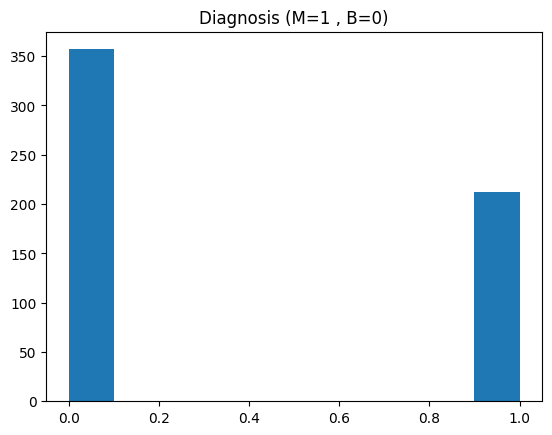

In [9]:
df.describe()
plt.hist(df['diagnosis'])
plt.title('Diagnosis (M=1 , B=0)')
plt.show()

<AxesSubplot: >

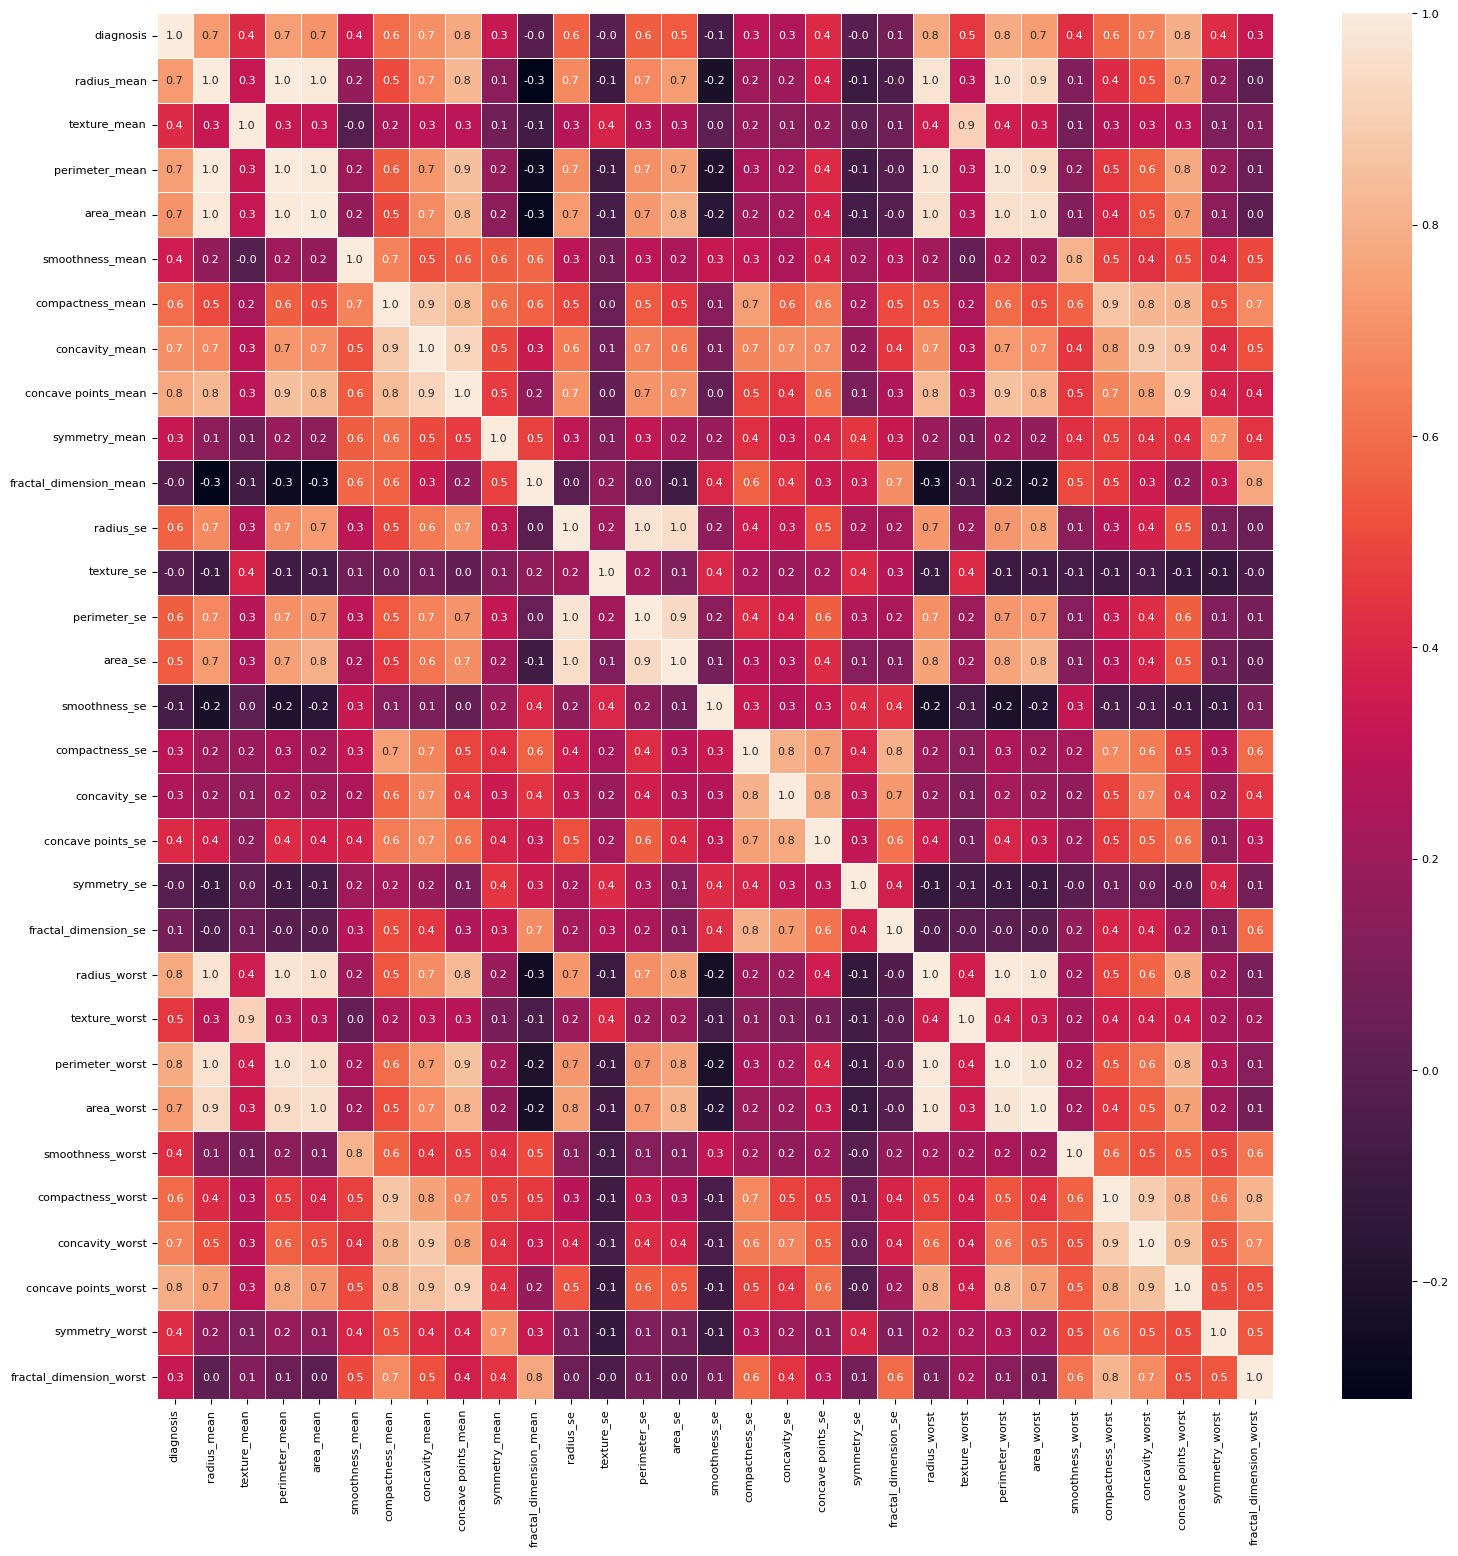

In [30]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

###Observations

1. mean values of cell radius, perimeter, area, compactness, concavity and concave points can be used in classification of the cancer. Larger values of these parameters tends to show a correlation with malignant tumors. 
2. mean values of texture, smoothness, symmetry or fractual dimension does not show a particular preference of one diagnosis over the other. In any of the histograms there are no noticeable large outliers that warrants further cleanup.

#### For the sake of simplicity for implementation we will choose 8 features to work with because too many features will be hard for the doctor to input so many features. These features are chosen based on their correlation to avoid using too linearly correlated features which does not add additional information to the classification task

Features of interest: 
1. concavity_mean
2. area_se
3. area_worst
4. concavity_worst
5. concavity_se
6. texture_mean
7. area_mean
8. symmetry_mean

In [35]:
feature_interest = ['concavity_mean','area_se','area_worst','concavity_worst','concavity_se','texture_mean','area_mean','symmetry_mean','diagnosis']

df_interest = df[feature_interest]
df_interest.head()

,concavity_mean,area_se,area_worst,concavity_worst,concavity_se,texture_mean,area_mean,symmetry_mean,diagnosis
0,0.3001,153.40,2019.0,0.7119,0.05373,10.38,1001.0,0.2419,1
1,0.0869,74.08,1956.0,0.2416,0.01860,17.77,1326.0,0.1812,1
2,0.1974,94.03,1709.0,0.4504,0.03832,21.25,1203.0,0.2069,1
3,0.2414,27.23,567.7,0.6869,0.05661,20.38,386.1,0.2597,1
4,0.1980,94.44,1575.0,0.4000,0.05688,14.34,1297.0,0.1809,1


## Training pipeline

The pipeline can be split into several components
1. Train test split
2. Normalisation
3. K Fold Cross validation
4. Model Selection
5. Training using full sample
6. Saving the trained model

In [41]:

def classification_model(model, data):
    #std = StandardScaler()
    model_name = type(model).__name__
    #Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=5)
    error = []
    for train, test in kf.split(data):
    # Filter training data
        train_X,train_y = data.iloc[train,:].drop('diagnosis', axis=1),data['diagnosis'].iloc[train]
        test_X, test_y = data.iloc[test,:].drop('diagnosis', axis=1),data['diagnosis'].iloc[test]

#         train_X_transform = std.fit_transform(train_X)
#         test_X_transform = std.transform(test_X)
        # Training the algorithm using the predictors and target.
        
        model.fit(train_X, train_y)
        
        y_test_pred = model.predict(test_X)
        
        F1_score = f1_score(test_y,y_test_pred, average = 'macro')

        #Record error from each cross-validation run
        error.append(F1_score)

    
    return np.mean(np.array(error))

def pipeline(models,data):
    '''
    models (list): models to be tested
    data (pd.DataFrame)
    
    '''
    best_score = -1
    best_model = -1
    
    for model in models:
        error = classification_model(model,data)
        
        if error > best_score:
            best_score = error
            best_model = model
    
    print(f"Best model is {type(best_model).__name__}, with a 10 Fold CV F1 score of {best_score}")
    
    X_whole, y_whole = data.drop('diagnosis', axis=1),data['diagnosis']
#     std = StandardScaler()
#     data_transform = std.fit_transform(X_whole)
    best_model.fit(X_whole,y_whole)
    y_pred_whole = best_model.predict(X_whole)
    error_whole = f1_score(y_whole,y_pred_whole, average = 'macro')
    
    print()
    print(f"Using the whole data to train the best deduced model our F1 score: {error_whole}")
    
    return best_model
        
    


In [43]:
models = [LogisticRegression(), RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2), xgb.XGBClassifier()]

best_model = pipeline(models,df_interest)

C:\Users\overl\anaconda3\envs\dsa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\overl\anaconda3\envs\dsa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best model is XGBClassifier, with a 10 Fold CV F1 score of 0.9508699346465063

Using the whole data to train the best deduced model our F1 score: 1.0


In [45]:
# save the model 
vars(best_model)

{'use_label_encoder': None,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'max_depth': None,
 'max_leaves': None,
 'max_bin': None,
 'grow_policy': None,
 'learning_rate': None,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': None,
 'min_child_weight': None,
 'max_delta_step': None,
 'subsample': None,
 'sampling_method': None,
 'colsample_bytree': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'random_state': None,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': None,
 'gpu_id': None,
 'validate_parameters': None,
 'predictor': None,
 'enable_categorical': False,
 'feature_types': None,
 'max_cat_to_onehot': None,
 'max_cat_threshold': None,
 'eval_metric': None,
 'early_stopping_rounds': None,
 'callbacks': None,
 'classes_': array([0, 1], dtype=int64),

In [48]:
pickle.dump(best_model, open('xgb_breast_classifier.pkl', "wb"))

In [50]:
xgb_model_loaded = pickle.load(open('xgb_breast_classifier.pkl', "rb"))

In [51]:
xgb_model_loaded.predict(df_interest.drop('diagnosis', axis=1))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,